# ========================================================
# Dark URL Detection
# Adrien Manciet - Thibault Sourdeval
# ========================================================

Ce dataset est un ensemble d'url qui sont labellisés. Si le label vaut 1, l'url est dangereux, si il vaut -1, il ne l'est pas. L'objectif sera de faire un algorithme de classification des url en apprenant sur le dataset disponible. 

# =========================
# Partie 1 : Phase d'exploration
# =========================

Nous notons que les fichiers de données sont sous la forme de matrices sparse. Cela signifie que seules les valeurs non nulles sont gardées en mémoire. 
Cela permet d'épargner des erreurs de mémoire. 

Le fichier features contient des numéros qui semblent correspondre à des subdivisions de l'url contenant en blocs. Exemple : la première ligne du fichier features affiche 4, ce qui pourrait correspondre aux quatres premiers caractères de l'url 'http'. 

Nous codons une fonction de prévisualisation pour mieux comprendre la structure des données en les transformant en un dataframe. Pour la suite, 
nous resterons dans le format de données initial.

**Fonction de prévisualisation** 

In [3]:
from sklearn.datasets import load_svmlight_file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def preview_data(day, nb_lines, nb_cols, random = True):
    # Si random est laissé tel quel, une valeur au hasard 
    # est prise pour la première ligne et la première colonne à afficher

    path =f"url_svmlight/url_svmlight/Day{day}.svm"
    X, y = load_svmlight_file(path)
    print(X.shape)

    if random == True:
        start_line = np.random.randint(0, len(y)-nb_lines)
        start_col = np.random.randint(0,X.shape[1])
    else : 
        start_line = int(input("Première ligne à afficher : "))
        start_col = int(input("Première colonne à afficher : "))
    
    label_list = []
    for i in range(start_col, start_col+nb_cols):
        label_list.append(i)

    X_df = pd.DataFrame(X[start_line: start_line+nb_lines, start_col: start_col+nb_cols].toarray(), columns=label_list)
    y_df = pd.DataFrame(y[start_line: start_line+nb_lines], columns=['label'])

    data = pd.concat([X_df, y_df], axis=1)
    return data

preview_data(17, 10, 10, random=False)


(20000, 3231939)


,15,16,17,18,19,20,21,22,23,24,label
0,0.0,0.764849,0.845011,0.601523,0.0,0.142856,0.142857,0.000000,1.0,0.0,-1.0
1,0.0,0.635525,0.805155,0.470136,0.0,0.142856,0.142857,0.142857,1.0,0.0,-1.0
2,0.0,0.676108,0.847691,0.185432,0.0,0.142856,0.142857,0.000000,0.0,0.0,-1.0
3,0.1,0.915305,0.000000,0.202819,0.0,0.000990,0.000992,0.000000,0.0,0.0,1.0
4,0.0,0.000000,0.000000,0.000000,0.0,0.002975,0.002976,0.000000,1.0,1.0,1.0
5,0.0,0.645411,0.822980,0.854082,0.0,0.023808,0.023810,0.023810,1.0,0.0,-1.0
6,0.0,0.735888,0.816571,0.146394,1.0,0.285711,0.005952,0.000000,0.0,0.0,-1.0
7,0.0,0.760097,0.737675,0.583909,0.0,0.285713,0.011905,0.000000,1.0,1.0,-1.0
8,0.0,0.619469,0.752946,0.497025,0.0,0.035713,0.035714,0.035714,1.0,1.0,-1.0
9,0.0,0.707573,0.749562,0.389203,0.0,0.142856,0.002976,0.002976,1.0,1.0,-1.0


**Visualisations grahiques** 

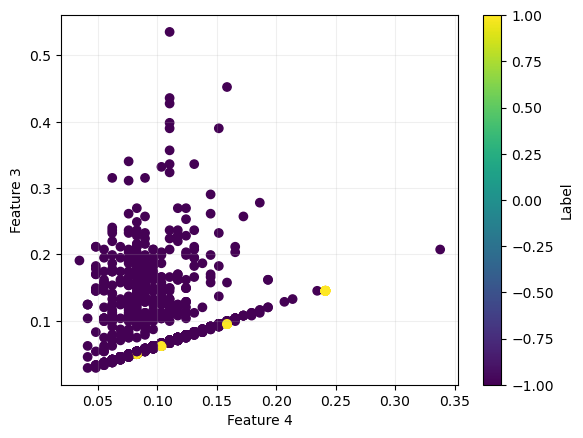

In [4]:
def scatter_plot(day, feature_x, feature_y): 
    path =f"url_svmlight/url_svmlight/Day{day}.svm"
    X, y = load_svmlight_file(path)

    X = X[0:1000,:1000].toarray()
    plt.figure()
    plt.grid(alpha=0.2)
    sc = plt.scatter(X[:,feature_x], X[:,feature_y], c=y[0:1000], cmap="viridis")
    plt.xlabel(f'Feature {feature_x}')
    plt.ylabel(f'Feature {feature_y}')
    

    cbar = plt.colorbar(sc)
    cbar.set_label("Label")
    plt.show()

scatter_plot(11,4,3)

# =========================
# Partie 2 : Feature Engineering
# =========================

Nous commençons par une pca brute pour voir ce que cela peut donner. 

**PCA**


[0.01397283 0.10636171]


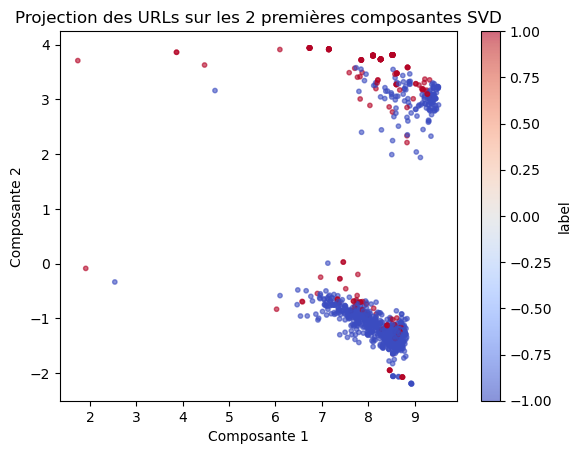

In [5]:
from sklearn.decomposition import TruncatedSVD

X, y = load_svmlight_file('url_svmlight/url_svmlight/Day96.svm')

svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X)
print(svd.explained_variance_ratio_)
plt.scatter(X_svd[:1000,0], X_svd[:1000,1], c=y[:1000], cmap='coolwarm', s=10, alpha=0.6)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.title('Projection des URLs sur les 2 premières composantes SVD')
plt.colorbar(label='label')
plt.show()

Constatant l'efficacité toute relative de cette PCA, nous décidons de retravailler sur les données d'entrées afin d'éliminer dès le départ des features à trop faible variance.
Nous remarquons que beaucoup de colonnes sont nulles sur la prévisualisation, il faut les retirer du dataset. 
La difficulté est de parcourir tous les fichiers svm. 

Comme beaucoup de nos colonnes de features ne contiennent que des 0 ou des 1, et que cela ne permettra pas la classification, nous décidons d'enlever ces colonnes dans les données qui serveront à l'apprentissage. 

Pour ce faire, nous utilisons un critère sur la variance minimale d'une colonne dans chaque fichier. Puis, nous regardons le nombre de fichier pour lesquels une colonne a été gardée. Nous mesurons cela en pourcentage. Exemple : la colonne 1 a une variance supérieure au critère minimal dans les fichiers 1 à 10, mais pas dans les fichiers 11 à 20. Ainsi, l'algorithme a gardé la colonne un pour les fichiers 1 à 10 et l'a enlevée dans les autres. Au total, la colonne 1 a été gardée dans 50% des cas.

Dans un premier temps, nous gardons les colonnes dès lors qu'elles sont gardées au moins une fois, soit que leur pourcentage d'apparition est strictement positif. Nous pourrons raffiner cela pour garder moins de features si on voit que cela améliore la performance de la méthode d'apprentissage.

In [6]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import load_svmlight_file
import os

data_dir = "url_svmlight/url_svmlight"
max_features = 3300000  # à adapter à ton dataset

selector = VarianceThreshold(threshold=0.1)

# Préparer la liste des fichiers à traiter
files_to_process = sorted(os.listdir(data_dir))[:10]  # exemple sur 10 jours
num_files = len(files_to_process)

# Initialiser UN SEUL tableau pour compter les sélections
# C'est beaucoup plus efficace en mémoire
column_keep_counts = np.zeros(max_features, dtype=int)

print(f"Traitement de {num_files} fichiers...")

# Boucle sur les fichiers
for file in files_to_process:
    X, y = load_svmlight_file(os.path.join(data_dir, file), n_features=max_features)
    
    # On a seulement besoin de "fit", pas de "fit_transform" si on n'utilise pas X_reduced
    selector.fit(X) 
    
    keep_mask = selector.get_support()  # booléen : True si la colonne est gardée
    
    # --- La voici, l'optimisation ---
    # On ajoute le masque (True=1, False=0) à notre compteur total
    column_keep_counts += keep_mask
    # ---------------------------------
    print(f"Traitement {file} terminé.")

print("Traitement terminé.")

# Calculer le pourcentage (exactement comme avant, mais sans la grosse matrice)
column_keep_percentage = (column_keep_counts / num_files) * 100

# Créer DataFrame en ne gardant que les colonnes qui ont été sélectionnées au moins une fois
df_keep = pd.DataFrame({
    'column_index': np.arange(len(column_keep_percentage)),
    'percent_kept': column_keep_percentage
})

# Filtrer les colonnes jamais gardées
df_keep = df_keep[df_keep['percent_kept'] > 0]	

Traitement de 10 fichiers...
Traitement Day0.svm terminé.
Traitement Day1.svm terminé.
Traitement Day10.svm terminé.
Traitement Day100.svm terminé.
Traitement Day101.svm terminé.
Traitement Day102.svm terminé.
Traitement Day103.svm terminé.
Traitement Day104.svm terminé.
Traitement Day105.svm terminé.
Traitement Day106.svm terminé.
Traitement terminé.


In [7]:
import numpy as np
from scipy.sparse import vstack, csr_matrix
from sklearn.datasets import load_svmlight_file

data_dir = "url_svmlight/url_svmlight"

X_filtered_all = None
y_all = []

# -------------------------------
# Boucle sur les fichiers
# -------------------------------
for file in sorted(os.listdir(data_dir))[:10]:
    print(f"Traitement de {file}...")
    X, y = load_svmlight_file(os.path.join(data_dir, file), n_features=max_features)
    
    # Filtrage sur les mêmes colonnes
    X_filtered = X[:, df_keep['column_index']]
    
    # Concaténation verticale
    if X_filtered_all is None:
        X_filtered_all = X_filtered
    else:
        X_filtered_all = vstack([X_filtered_all, X_filtered])
    
    y_all.append(y)

# -------------------------------
# 5️⃣ Concaténer les labels
# -------------------------------
y_all = np.concatenate(y_all)

# -------------------------------
# 6️⃣ Vérification finale
# -------------------------------
print("Shape finale :", X_filtered_all.shape)
print("Nombre total d'échantillons :", X_filtered_all.shape[0])
print("Nombre de colonnes (features) :", X_filtered_all.shape[1])


Traitement de Day0.svm...
Traitement de Day1.svm...
Traitement de Day10.svm...
Traitement de Day100.svm...
Traitement de Day101.svm...
Traitement de Day102.svm...
Traitement de Day103.svm...
Traitement de Day104.svm...
Traitement de Day105.svm...
Traitement de Day106.svm...
Shape finale : (196000, 81)
Nombre total d'échantillons : 196000
Nombre de colonnes (features) : 81


On créé un dataset train/test sur l'ensemble des données

In [8]:
from sklearn.model_selection import train_test_split

# X = votre matrice de features complète
# y = votre vecteur de cibles complet

# Définir la taille du jeu de test (ex: 20%)
TAILLE_TEST = 0.2

# 1. Créer le split principal (Train / Test)
# Le jeu de test (X_test, y_test) ne sera plus touché avant l'évaluation finale.
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_filtered_all, 
    y_all, 
    test_size=TAILLE_TEST, 
    stratify=y_all,  # Garde les proportions de classes
    random_state=42 # Pour la reproductibilité
)

print(f"Taille dataset complet : {X_filtered_all.shape[0]} échantillons")
print(f"Taille jeu d'entraînement complet : {X_train_full.shape[0]} échantillons")
print(f"Taille jeu de test : {X_test.shape[0]} échantillons")

Taille dataset complet : 196000 échantillons
Taille jeu d'entraînement complet : 156800 échantillons
Taille jeu de test : 39200 échantillons


Maintenant on va choisir aléatoirement une petite partie du dataset train pour entrainer notre modèle

In [9]:
# Définir la fraction du jeu d'entraînement que vous voulez garder
# Ex: 0.1 (soit 10% du X_train_full, ou 8% du dataset total)
TAILLE_TRAIN_REDUIT = 0.1 

# 2. Créer l'échantillon réduit à partir du jeu d'entraînement
# On utilise train_size cette fois-ci.
# Les '_' sont pour les variables que nous n'utiliserons pas (le reste des données)
X_train_reduced, _, y_train_reduced, _ = train_test_split(
    X_train_full, 
    y_train_full, 
    train_size=TAILLE_TRAIN_REDUIT, 
    stratify=y_train_full, # Garde les proportions de classes
    random_state=42
)

print(f"\nTaille jeu d'entraînement réduit : {X_train_reduced.shape[0]} échantillons")


Taille jeu d'entraînement réduit : 15680 échantillons


# =========================
# Partie 3 : Phase d'apprentissage
# =========================

On va commencer par évaluer les performances d'un svm linéaire :

**SVM Linéaire**

In [29]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


linear_svm = svm.SVC(kernel='linear', C=1)
linear_svm.fit(X_train_reduced,y_train_reduced)

y_pred = linear_svm.predict(X_test)

print("\n--- Évaluation du modèle ---")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nMatrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))


--- Évaluation du modèle ---
Accuracy : 0.9668367346938775

Matrice de confusion :
 [[24469   747]
 [  553 13431]]

Rapport de classification :
               precision    recall  f1-score   support

        -1.0       0.98      0.97      0.97     25216
         1.0       0.95      0.96      0.95     13984

    accuracy                           0.97     39200
   macro avg       0.96      0.97      0.96     39200
weighted avg       0.97      0.97      0.97     39200



In [10]:
#SVM
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from time import time

TAILLE_TRAIN_REDUIT = 0.01

X_train_reduced_svm, _, y_train_reduced_svm, _ = train_test_split(
    X_train_full, 
    y_train_full, 
    train_size=TAILLE_TRAIN_REDUIT, 
    stratify=y_train_full, # Garde les proportions de classes
    random_state=42
)

# Normalisation recommandée pour SVM RBF
scaler = StandardScaler(with_mean=False)
X_train_reduced_svm = scaler.fit_transform(X_train_reduced_svm)

# =========================
# 3️⃣ Entraînement SVM (kernel trick)
# =========================
print("\n--- Entraînement du SVM avec noyau RBF ---")

svm_model = SVC(
    kernel='rbf',     # 'linear', 'poly', 'rbf', 'sigmoid'...
    C=1.0,            # paramètre de régularisation
    gamma='scale',    # influence du noyau RBF (auto ou 'scale')
    class_weight='balanced',  # utile si les classes sont déséquilibrées
)

t0 = time()
svm_model.fit(X_train_reduced_svm, y_train_reduced_svm)
t1 = time()

print(f"✅ Modèle entraîné en {t1 - t0:.2f} secondes")

# =========================
# 4️⃣ Évaluation
# =========================
y_pred = svm_model.predict(X_test)

print("\n--- Évaluation du modèle ---")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nMatrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))



--- Entraînement du SVM avec noyau RBF ---
✅ Modèle entraîné en 0.18 secondes

--- Évaluation du modèle ---
Accuracy : 0.8043877551020409

Matrice de confusion :
 [[17716  7500]
 [  168 13816]]

Rapport de classification :
               precision    recall  f1-score   support

        -1.0       0.99      0.70      0.82     25216
         1.0       0.65      0.99      0.78     13984

    accuracy                           0.80     39200
   macro avg       0.82      0.85      0.80     39200
weighted avg       0.87      0.80      0.81     39200



In [11]:
from sklearn.naive_bayes import BernoulliNB
gnb = BernoulliNB()
gnb.fit(X_train_reduced.toarray(),y_train_reduced)

y_pred = gnb.predict(X_test.toarray())

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("=== Résultats du modèle Naive Bayes ===")
print(f"Précision : {accuracy:.2f}")
print("\nMatrice de confusion :\n", cm)
print("\nRapport de classification :\n", report)

=== Résultats du modèle Naive Bayes ===
Précision : 0.90

Matrice de confusion :
 [[23612  1604]
 [ 2498 11486]]

Rapport de classification :
               precision    recall  f1-score   support

        -1.0       0.90      0.94      0.92     25216
         1.0       0.88      0.82      0.85     13984

    accuracy                           0.90     39200
   macro avg       0.89      0.88      0.88     39200
weighted avg       0.89      0.90      0.89     39200



In [20]:
from sklearn.gaussian_process import GaussianProcessClassifier

TAILLE_TRAIN_REDUIT = 0.001

X_train_reduced_gp, _, y_train_reduced_gp, _ = train_test_split(
    X_train_full, 
    y_train_full, 
    train_size=TAILLE_TRAIN_REDUIT, 
    stratify=y_train_full, # Garde les proportions de classes
    random_state=42
)

spam_GP = GaussianProcessClassifier()
spam_GP.fit(X_train_reduced_gp.toarray(),y_train_reduced_gp)

y_pred = spam_GP.predict(X_test.toarray())

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("=== Résultats du modèle Gaussian Process ===")
print(f"Précision : {accuracy:.2f}")
print("\nMatrice de confusion :\n", cm)
print("\nRapport de classification :\n", report)

=== Résultats du modèle Gaussian Process ===
Précision : 0.90

Matrice de confusion :
 [[24381   835]
 [ 2952 11032]]

Rapport de classification :
               precision    recall  f1-score   support

        -1.0       0.89      0.97      0.93     25216
         1.0       0.93      0.79      0.85     13984

    accuracy                           0.90     39200
   macro avg       0.91      0.88      0.89     39200
weighted avg       0.91      0.90      0.90     39200



On va maintenant essayer d'entrainer un classifieur grâce à des arbres de décision :

**DecisionTree**

In [27]:
from sklearn import tree
forest = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)
forest.fit(X_train_reduced,y_train_reduced)

y_pred = forest.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("=== Résultats du modèle DecisionTree ===")
print(f"Précision : {accuracy:.2f}")
print("\nMatrice de confusion :\n", cm)
print("\nRapport de classification :\n", report)

=== Résultats du modèle DecisionTree ===
Précision : 0.95

Matrice de confusion :
 [[23935  1281]
 [  514 13470]]

Rapport de classification :
               precision    recall  f1-score   support

        -1.0       0.98      0.95      0.96     25216
         1.0       0.91      0.96      0.94     13984

    accuracy                           0.95     39200
   macro avg       0.95      0.96      0.95     39200
weighted avg       0.96      0.95      0.95     39200



**AdaBoost**

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
boosted_forest = AdaBoostClassifier(tree.DecisionTreeClassifier(criterion='entropy',max_depth=3), n_estimators=100)
boosted_forest.fit(X_train_reduced,y_train_reduced)

y_pred = boosted_forest.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("=== Résultats du modèle AdaBoost ===")
print(f"Précision : {accuracy:.2f}")
print("\nMatrice de confusion :\n", cm)
print("\nRapport de classification :\n", report)

=== Résultats du modèle AdaBoost ===
Précision : 0.97

Matrice de confusion :
 [[24617   599]
 [  617 13367]]

Rapport de classification :
               precision    recall  f1-score   support

        -1.0       0.98      0.98      0.98     25216
         1.0       0.96      0.96      0.96     13984

    accuracy                           0.97     39200
   macro avg       0.97      0.97      0.97     39200
weighted avg       0.97      0.97      0.97     39200



In [24]:
from sklearn.ensemble import GradientBoostingClassifier

gtb = GradientBoostingClassifier(n_estimators=100)
gtb.fit(X_train_reduced,y_train_reduced)


y_pred = gtb.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("=== Résultats du modèle XGBoost ===")
print(f"Précision : {accuracy:.2f}")
print("\nMatrice de confusion :\n", cm)
print("\nRapport de classification :\n", report)

=== Résultats du modèle XGBoost ===
Précision : 0.97

Matrice de confusion :
 [[24616   600]
 [  580 13404]]

Rapport de classification :
               precision    recall  f1-score   support

        -1.0       0.98      0.98      0.98     25216
         1.0       0.96      0.96      0.96     13984

    accuracy                           0.97     39200
   macro avg       0.97      0.97      0.97     39200
weighted avg       0.97      0.97      0.97     39200



**RandomForest**

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=101, criterion='entropy')
rf.fit(X_train_reduced,y_train_reduced)

y_pred = rf.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("=== Résultats du modèle Random Forest ===")
print(f"Précision : {accuracy:.2f}")
print("\nMatrice de confusion :\n", cm)
print("\nRapport de classification :\n", report)

=== Résultats du modèle Random Forest ===
Précision : 0.97

Matrice de confusion :
 [[24701   515]
 [  546 13438]]

Rapport de classification :
               precision    recall  f1-score   support

        -1.0       0.98      0.98      0.98     25216
         1.0       0.96      0.96      0.96     13984

    accuracy                           0.97     39200
   macro avg       0.97      0.97      0.97     39200
weighted avg       0.97      0.97      0.97     39200

